# Problem

Task: Catch Joe

Task scope and expectations:
* The purpose of this task is to analyze the data and build a model that solves the
specified problem.
* We want to see how you explore the data, identify the most important features, track
experiments, summarize your findings and use the data to build a working AI solution.
* We want to see you understand how to set up a proper project infrastructure, show
knowledge of simple problem solving, and knowledge of using your preferred
frameworks and libraries.
* The task has certain objective target metrics, but your approach and presentation are
also taken into account.
* Please make sure that your model is easy to run and reproduce.

Task details

Download the dataset here:

https://drive.google.com/file/d/1yXPQF3ED6pFLBiKsr-BL3fu-t0yY7KAY/view?usp=sharing

The dataset contains data about user sessions that have been recorded over a period of
time. The dataset consists of two parts: the training dataset where user ID's are labeled, and
the verification set without labels.

Each session is represented by a JSON object with the following fields:
* "user_id" is the unique identifier of the user.
* "browser", "os", "locale" contain info about the software on the user's machine.
* "gender", "location" give analytics data about the user.
* "date" and "time" is the moment when the session started (in GMT).
* "sites" is a list of up to 15 sites visited during the session. For each site, the URL and
the length of visit in seconds are given.

The goal is to create a method to identify the user with id=0 (codename Joe) specifically.

Your solution should contain:
* Exploratory data analysis, either as a standalone report/presentation or in the form of
a Jupyter notebook
* A standalone script that runs the whole pipeline on the verification set and creates a
file where each line is the predicted label (0 = Joe, 1 = not Joe)
* File result.csv containing the predictions for the test set.

# Summary

The notebook contains the following sections:

1. Setup
    * imports
    * constants
    * functions
2. Data
    * EDA
    * Presprocessing
3. Model
    * Baseline
    * Advanced algorithm
4. Final algorithm

# The script

#### Installation

Make sure you set up the environment from the `requrements.txt`.

#### Usage

Simply run the `script.py` in the CLI:
```python
python -m script "file_name.json"
```

# Setup

## Imports

In [2]:
import numpy as np
import pandas as pd
import random
import os
import json
import seaborn as sns
from collections import Counter, defaultdict as ddict
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from matplotlib import pyplot
import pickle

warnings.filterwarnings("ignore")
%matplotlib inline

## Constants

In [3]:
DATASET_PATH = "data/dataset.json"

# Reproducability
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Functions

In [4]:
def gen_date(df: pd.DataFrame, date_feature_name='date') -> pd.DataFrame:
    """
    This function generates a set of date related features.
    
    :param df: The initial dataset with the "date" feature. 
    :param date_feature_name: The name of the "date" feature. 
    :return: The dataframe with the generated features.
    """
    
    df = df[[date_feature_name]].copy()
    df[date_feature_name] = pd.to_datetime(df[date_feature_name], format='%Y-%m-%d')
        
    df['sin_minute'] = np.sin(2*np.pi*df[date_feature_name].dt.minute/60)
    df['cos_minute'] = np.cos(2*np.pi*df[date_feature_name].dt.minute/60)
    df['sin_hour'] = np.sin(2*np.pi*df[date_feature_name].dt.hour/24)
    df['cos_hour'] = np.cos(2*np.pi*df[date_feature_name].dt.hour/24)

    dw_mapping={
        0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', \
        5: 'Saturday', 6: 'Sunday'
    }
    df['day_of_week'] = df[date_feature_name].dt.weekday.map(dw_mapping)
    for v in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', \
              'Saturday', 'Sunday']:
        df[v] = df['day_of_week'] == v
        df[v] = df[v].astype(int)
    df.drop('day_of_week', axis=1, inplace=True) 

    df.drop(date_feature_name, axis=1, inplace=True)
    return df

In [5]:
def to_dict(x):
    res = ddict(int)
    for xx in x:
        res[xx['site']] += xx['length']
    return res


def gen_topn_sites(X_train, X_test, y_train, n=30):
    """
    This function generates a set of features based on the sites used by the target user.
    
    :param X_train: X_train.
    :param y_train: y_train. 
    :param n: The number of the top-k frequent websites. 
    :return: The dataframe with the generated features.
    """
    X_train, X_test, y_train = X_train.copy(), X_test.copy(), y_train.copy()
    site_counter_0 = ddict(int)
    for (_, u1), (_, u2) in zip(X_train.iterrows(), y_train.iterrows()):
        if u2['target'] == 1:
            continue
        for site in u1['sites']:
            site_name = site['site']
            site_counter_0[site_name] += site['length']
    site_counter_0 = Counter(site_counter_0)
    df_0_sites = pd.DataFrame(site_counter_0.items()) \
        .rename(columns={0: "website", 1: "visits"}) \
        .sort_values("visits", ascending=False)
    new_features = list(df_0_sites['website'][:n])
    
    X_train_sites_ = X_train['sites'].apply(to_dict)
    X_test_sites_ = X_test['sites'].apply(to_dict)

    for col in new_features:
        X_train[col] = X_train_sites_.apply(lambda x: x[col] if col in x else 0.0)
        X_test[col] = X_test_sites_.apply(lambda x: x[col] if col in x else 0.0)
        
    X_train = X_train.drop(['sites'], axis=1)
    X_test = X_test.drop(['sites'], axis=1)
    return X_train, X_test, new_features

# Data

## EDA

### General

In this section we get the general information regarding the given dataset.

In [6]:
with open(DATASET_PATH) as f:
    d = json.load(f)

In [7]:
df = pd.DataFrame(d)

In [8]:
df

,browser,os,locale,user_id,gender,location,sites,time,date
0,Chrome,Windows 8,de-DE,164,m,Canada/Toronto,"[{'site': 'lenta.ru', 'length': 296}, {'site':...",03:57:00,2016-08-14
1,Chrome,Windows 10,pt-PT,99,f,Netherlands/Amsterdam,"[{'site': 'windowsupdate.com', 'length': 56}, ...",13:52:00,2016-05-31
2,Chrome,Windows 10,bg-BG,28,m,Brazil/Rio de Janeiro,"[{'site': 'slack.com', 'length': 158}, {'site'...",17:40:00,2019-04-15
3,Internet Explorer,Ubuntu,en-US,163,f,New Zealand/Auckland,"[{'site': 'amazon.com', 'length': 168}, {'site...",20:23:00,2018-03-25
4,Firefox,Debian,ro-RO,177,f,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 43}, {'site': 'm...",01:10:00,2018-09-08
...,...,...,...,...,...,...,...,...,...
159995,Chrome,Windows 8,bg-BG,74,f,China/Shanghai,"[{'site': 'amazon.com', 'length': 54}, {'site'...",22:33:00,2018-10-15
159996,Internet Explorer,Ubuntu,fr-FR,163,f,New Zealand/Auckland,"[{'site': 'microsoft.com', 'length': 278}, {'s...",21:29:00,2016-03-23
159997,Chrome,Ubuntu,ja-JP,114,m,Russia/Moscow,"[{'site': 'googleapis.com', 'length': 86}, {'s...",19:00:00,2019-03-03
159998,Safari,MacOS,it-IT,48,m,Italy/Rome,"[{'site': 'live.com', 'length': 145}, {'site':...",16:44:00,2016-12-14


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   browser   160000 non-null  object
 1   os        160000 non-null  object
 2   locale    160000 non-null  object
 3   user_id   160000 non-null  int64 
 4   gender    160000 non-null  object
 5   location  160000 non-null  object
 6   sites     160000 non-null  object
 7   time      160000 non-null  object
 8   date      160000 non-null  object
dtypes: int64(1), object(8)
memory usage: 11.0+ MB


We can see there are no missing values.

In [10]:
df['user_id'] = df['user_id'].astype(str)
df['country'] = df['location'].apply(lambda x: x.split('/')[0])
df['city'] = df['location'].apply(lambda x: x.split('/')[1])
df['datetime'] = pd.to_datetime(df['date'] + ':' + df['time'], format = '%Y-%m-%d:%H:%M:%S')
df = df.sort_values(by='datetime')
df = df.drop(['date', 'time'], axis=1)

In [11]:
df.drop('sites', axis=1).describe(include='object')

,browser,os,locale,user_id,gender,location,country,city
count,160000,160000,160000,160000,160000,160000,160000,160000
unique,4,6,19,200,2,21,17,21
top,Chrome,Windows 10,ru-RU,79,m,Russia/Moscow,USA,Moscow
freq,83544,54341,16402,800,102400,14299,36329,14299


From the given features all of the can be considered as categorical.

### User ID

In [12]:
target_user_len = len(df[df['user_id'] == '0'])
print(f"Total samples: {len(df)}\nTarget samples: {target_user_len}")
print(f"Percentage: {100*target_user_len/len(df)}%")

Total samples: 160000
Target samples: 800
Percentage: 0.5%


Based on the percentage of the target class, the dataset is higly imbalanced. However, since there are 800 samples of the target class, we can't consider this problem as anomaly detection and will be working with a binary classification problem.

#### User 0

We define User 0 to be our target.

In [13]:
df_0_dt = df[df['user_id'] == '0'].drop(['sites', 'user_id'], axis=1)
df_0 = df_0_dt.drop(['datetime'], axis=1)
df_0.describe()

,browser,os,locale,gender,location,country,city
count,800,800,800,800,800,800,800
unique,2,2,1,1,4,4,4
top,Firefox,Ubuntu,ru-RU,m,France/Paris,France,Paris
freq,402,403,800,800,317,317,317


Let's take a look at the occurrence of different combinations of the user.

In [14]:
df_0.value_counts()

browser  os          locale  gender  location             country    city     
Firefox  Ubuntu      ru-RU   m       France/Paris         France     Paris        84
Chrome   Ubuntu      ru-RU   m       France/Paris         France     Paris        80
         Windows 10  ru-RU   m       France/Paris         France     Paris        80
Firefox  Windows 10  ru-RU   m       France/Paris         France     Paris        73
                                     USA/Chicago          USA        Chicago      52
Chrome   Ubuntu      ru-RU   m       USA/Chicago          USA        Chicago      51
Firefox  Ubuntu      ru-RU   m       Canada/Toronto       Canada     Toronto      49
Chrome   Windows 10  ru-RU   m       USA/Chicago          USA        Chicago      44
Firefox  Windows 10  ru-RU   m       Canada/Toronto       Canada     Toronto      44
Chrome   Ubuntu      ru-RU   m       Canada/Toronto       Canada     Toronto      43
         Windows 10  ru-RU   m       Canada/Toronto       Canada     To

In [15]:
for col in df_0.columns:
    vcs = dict(df_0[col].value_counts())
    print(f"\"{col}\": {vcs}")

"browser": {'Firefox': 402, 'Chrome': 398}
"os": {'Ubuntu': 403, 'Windows 10': 397}
"locale": {'ru-RU': 800}
"gender": {'m': 800}
"location": {'France/Paris': 317, 'USA/Chicago': 184, 'Canada/Toronto': 178, 'Singapore/Singapore': 121}
"country": {'France': 317, 'USA': 184, 'Canada': 178, 'Singapore': 121}
"city": {'Paris': 317, 'Chicago': 184, 'Toronto': 178, 'Singapore': 121}


In [16]:
df['target'] = (df['user_id'] == '0').astype(int).astype(str)

#### Ex. user 0

Here's the info without the user 0.

In [17]:
df_ex = df[df['target'] == '0']

In [18]:
for col in df_ex.drop(['sites', 'datetime', 'user_id', 'target'], axis=1).columns:
    vcs = dict(df_ex[col].value_counts())
    print(f"\"{col}\": {vcs}")

"browser": {'Chrome': 83146, 'Firefox': 34040, 'Safari': 28381, 'Internet Explorer': 13633}
"os": {'Windows 10': 53944, 'Windows 8': 43942, 'MacOS': 28381, 'Windows 7': 12830, 'Ubuntu': 11328, 'Debian': 8775}
"locale": {'ru-RU': 15602, 'bg-BG': 14375, 'nl-NL': 10836, 'de-DE': 10473, 'en-SG': 10047, 'ja-JP': 9571, 'ro-RO': 8869, 'en-CA': 8745, 'fr-FR': 8026, 'en-NZ': 7588, 'pt-PT': 7509, 'pt-BR': 7300, 'en-GB': 6795, 'it-IT': 6693, 'es-MX': 6428, 'en-US': 6392, 'pl-PL': 6372, 'uk-UA': 5197, 'en-AU': 2382}
"gender": {'m': 101600, 'f': 57600}
"location": {'Russia/Moscow': 14299, 'USA/New York': 11948, 'New Zealand/Auckland': 11210, 'Singapore/Singapore': 9739, 'USA/Miami': 9524, 'USA/Chicago': 8933, 'China/Shanghai': 8813, 'Japan/Tokyo': 8456, 'France/Paris': 8104, 'Italy/Rome': 7839, 'Malaysia/Kuala Lumpur': 7644, 'Netherlands/Amsterdam': 7297, 'Spain/Madrid': 6675, 'UK/London': 6600, 'Germany/Berlin': 5960, 'India/Delhi': 5882, 'USA/San Francisco': 5740, 'Canada/Toronto': 5457, 'Brazil/

### Browser

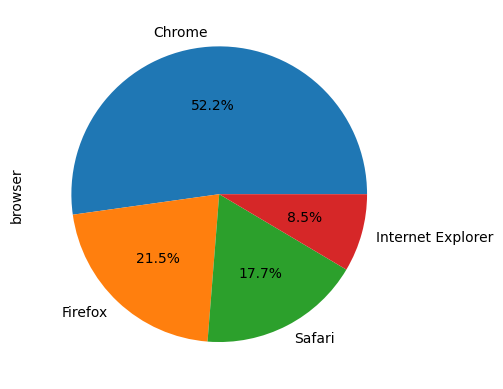

In [19]:
df['browser'].value_counts().plot.pie(autopct='%1.1f%%');

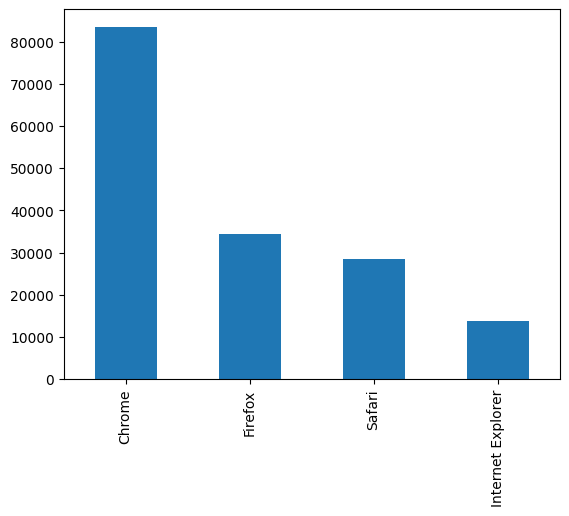

In [20]:
df['browser'].value_counts().plot.bar();

#### Browser (target user)

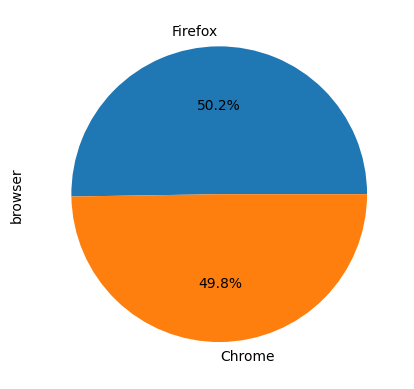

In [21]:
df_0['browser'].value_counts().plot.pie(autopct='%1.1f%%');

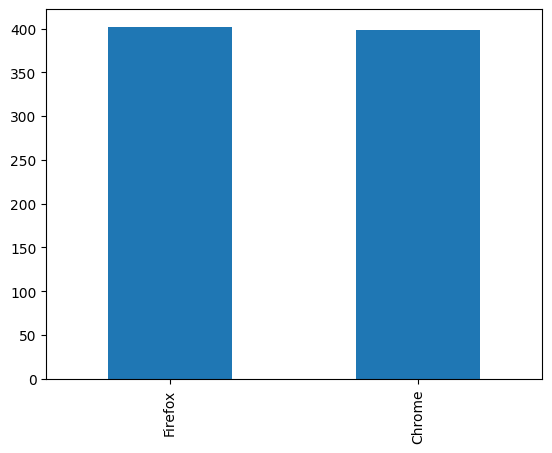

In [22]:
df_0['browser'].value_counts().plot.bar();

Our target user uses only Firefox and Chrome browsers. The frequency is almost equal.

### OS

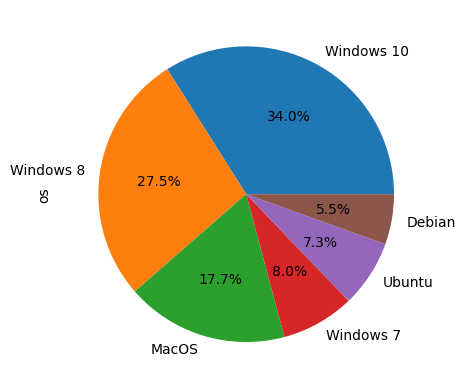

In [23]:
df['os'].value_counts().plot.pie(autopct='%1.1f%%');

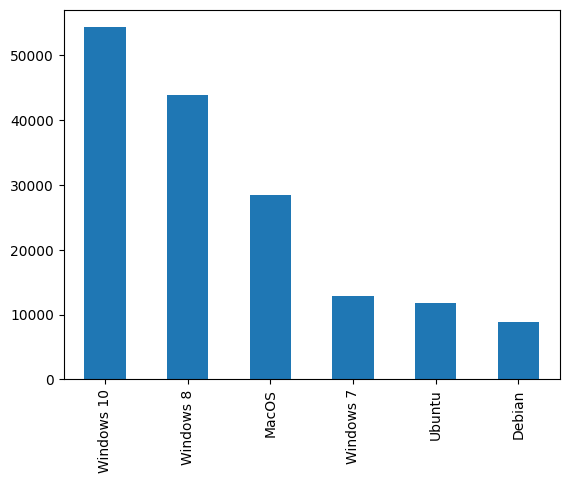

In [24]:
df['os'].value_counts().plot.bar();

#### OS (target user)

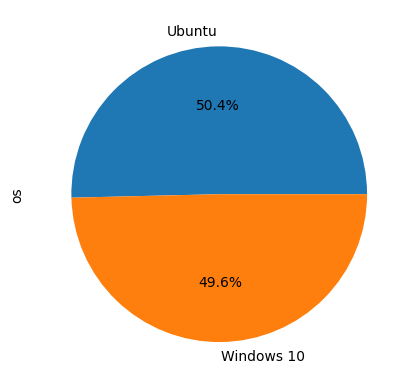

In [25]:
df_0['os'].value_counts().plot.pie(autopct='%1.1f%%');

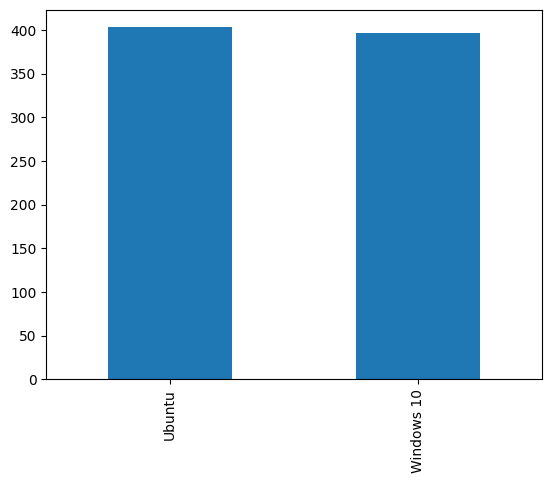

In [26]:
df_0['os'].value_counts().plot.bar();

The target user uses only Ubuntu and Windows 10. The frequency is almost equal.

### Locale

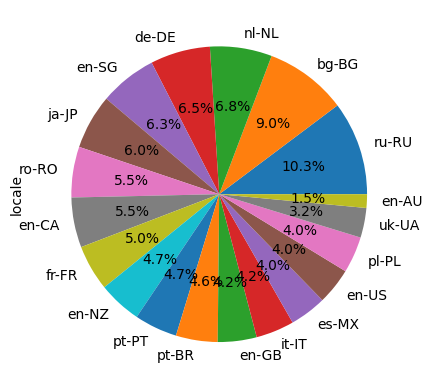

In [27]:
df['locale'].value_counts().plot.pie(autopct='%1.1f%%');

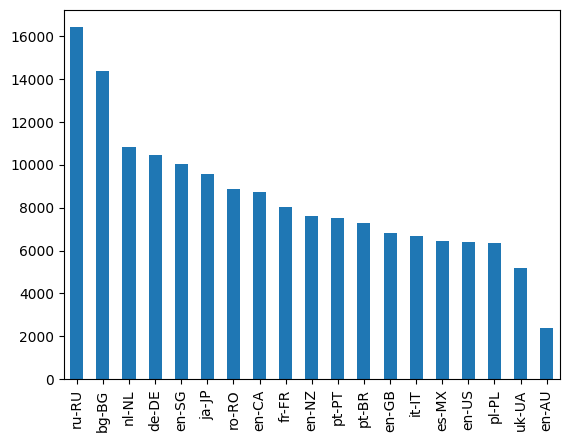

In [28]:
df['locale'].value_counts().plot.bar();

#### Locale (target user)

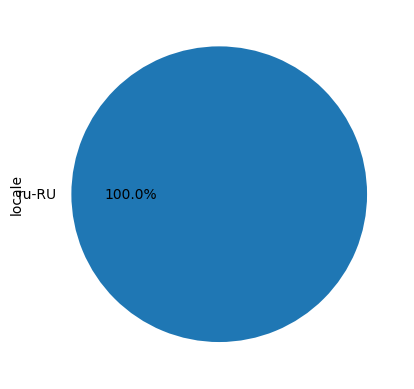

In [29]:
df_0['locale'].value_counts().plot.pie(autopct='%1.1f%%');

In [30]:
df['locale_ru'] = df['locale'] == "ru-RU"

The target user uses only "ru-RU" locale.

### Gender

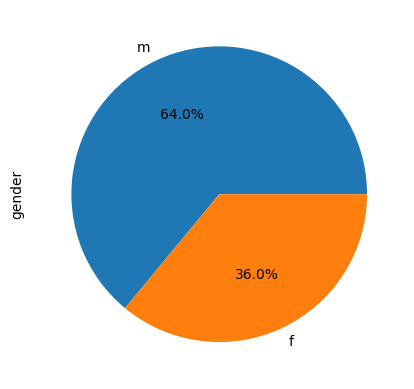

In [31]:
df['gender'].value_counts().plot.pie(autopct='%1.1f%%');

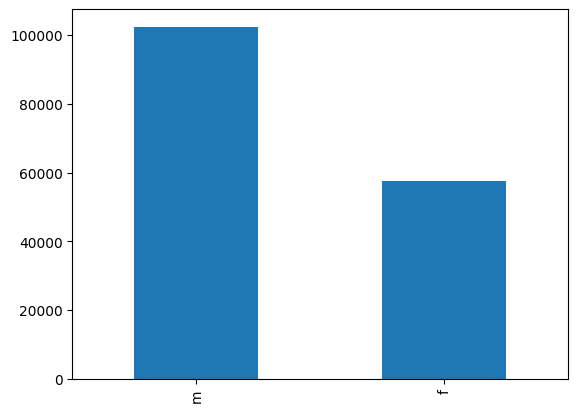

In [32]:
df['gender'].value_counts().plot.bar();

#### Gender (target user)

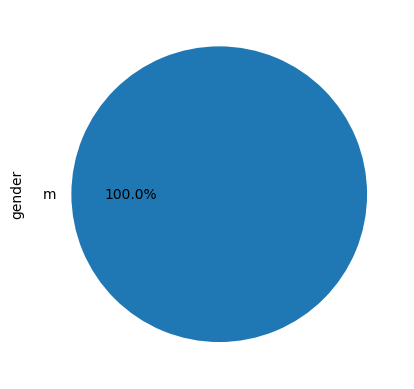

In [33]:
df_0['gender'].value_counts().plot.pie(autopct='%1.1f%%');

The gender of the target user is marked as masculine.

### Country

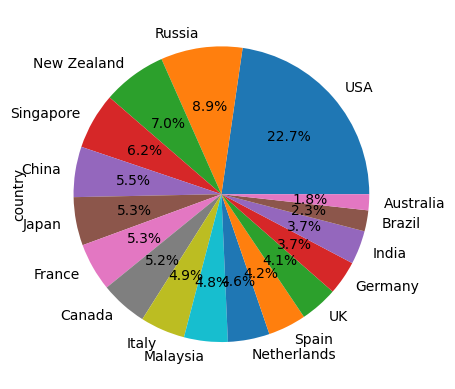

In [34]:
df['country'].value_counts().plot.pie(autopct='%1.1f%%');

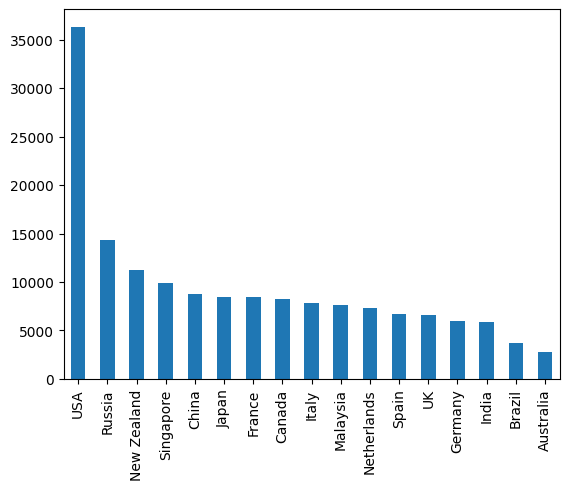

In [35]:
df['country'].value_counts().plot.bar();

#### Country (target user)

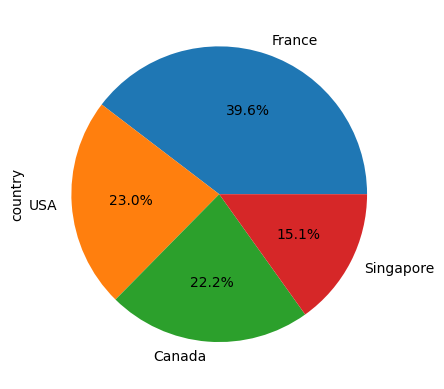

In [36]:
df_0['country'].value_counts().plot.pie(autopct='%1.1f%%');

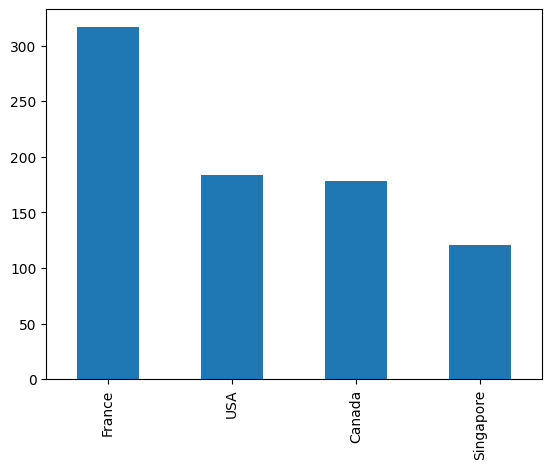

In [37]:
df_0['country'].value_counts().plot.bar();

Our terget user had sessions from 4 countries.

### City

Let's check if the number of cities is much higher than the number of countries.

In [38]:
df[['country', 'city']].groupby('country').value_counts()

country      city          
Australia    Sydney             2800
Brazil       Rio de Janeiro     3666
Canada       Toronto            5635
             Vancouver          2614
China        Shanghai           8813
France       Paris              8421
Germany      Berlin             5960
India        Delhi              5882
Italy        Rome               7839
Japan        Tokyo              8456
Malaysia     Kuala Lumpur       7644
Netherlands  Amsterdam          7297
New Zealand  Auckland          11210
Russia       Moscow            14299
Singapore    Singapore          9860
Spain        Madrid             6675
UK           London             6600
USA          New York          11948
             Miami              9524
             Chicago            9117
             San Francisco      5740
dtype: int64

We can leave only the `cities / location` feature without splitting it to `cities` and `location`, since the number of cities is almost equal to the number of countries.

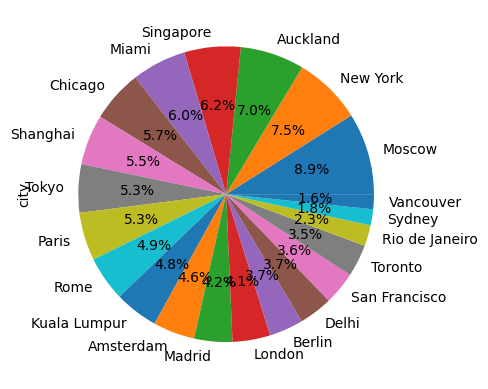

In [39]:
df['city'].value_counts().plot.pie(autopct='%1.1f%%');

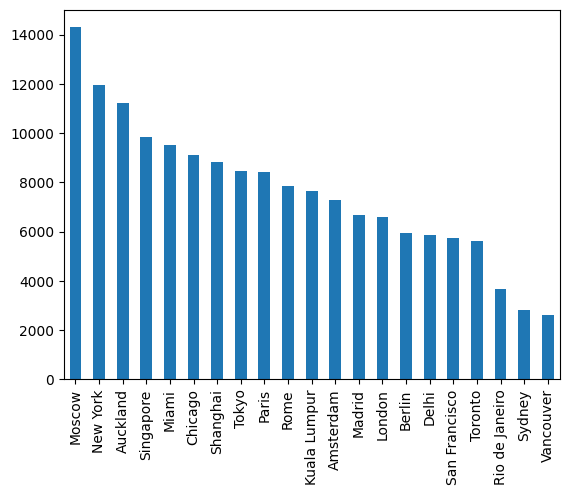

In [40]:
df['city'].value_counts().plot.bar();

#### City (target user)

Let's take a look at the cities of our target user.

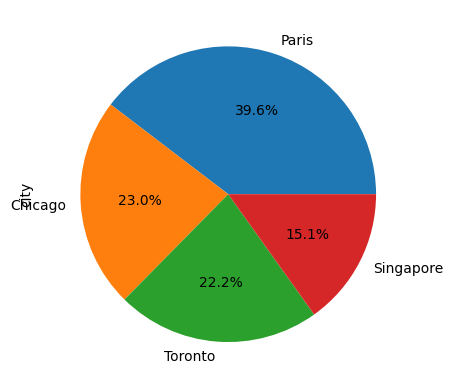

In [41]:
df_0['city'].value_counts().plot.pie(autopct='%1.1f%%');

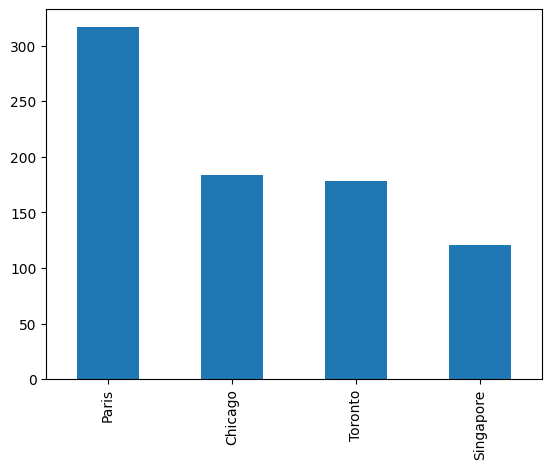

In [42]:
df_0['city'].value_counts().plot.bar();

Our target user had sessions only from the cities above. We need to check if they used VPN or traveled (see in a section below).

### Datetime

In [43]:
start = str(df['datetime'].min())
end = str(df['datetime'].max())
print(f"Start of the period: {start}\nEnd of the period: {end}")
n_days = (df['datetime'].max() - df['datetime'].min()).days
print(f"Days: {n_days}; Years: {round(n_days/365, 2)}")

Start of the period: 2016-01-14 12:42:00
End of the period: 2019-06-18 09:07:00
Days: 1250; Years: 3.42


In [44]:
start = str(df_0_dt['datetime'].min())
end = str(df_0_dt['datetime'].max())
print(f"Start of the period: {start}\nEnd of the period: {end}")
n_days = (df_0_dt['datetime'].max() - df_0_dt['datetime'].min()).days
print(f"Days: {n_days}; Years: {round(n_days/365, 2)}")

Start of the period: 2016-01-15 20:01:00
End of the period: 2019-04-21 14:31:00
Days: 1191; Years: 3.26


### Time

From all of the time features the most important for us is "hour", because it will help us to understand, at which part of the day a user is active.

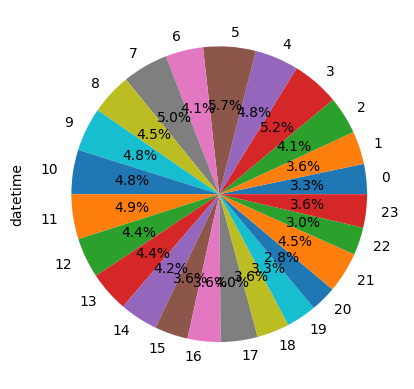

In [45]:
df['datetime'].apply(lambda x: x.hour).value_counts().sort_index().plot.pie(autopct='%1.1f%%');

Ex. target user:

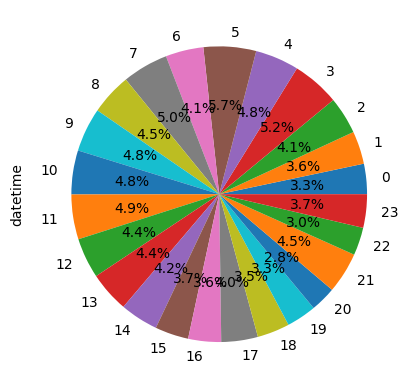

In [46]:
df_ex['datetime'].apply(lambda x: x.hour).value_counts().sort_index().plot.pie(autopct='%1.1f%%');

We can see that the users almost equally distributed in any hour of a day. Since there are sessions from different time zones, this distribution matches the expected.

#### Time (target user)

Let's take a look at the distribution of the User 0 sessions across the time depending on their location.

In [47]:
for country in df_0_dt['country'].unique():
    vc = df_0_dt[df_0_dt['country']==country]['datetime'].apply(lambda x: x.hour).value_counts()
    vc /= vc.sum()
    vc = dict(vc.apply(lambda x: round(x, 2)).sort_index())
    vc = "\n".join([f"{k}: {v}%" for k, v in vc.items()])
    print(f"{country}, active hours:\n{vc}")

France, active hours:
10: 0.26%
11: 0.21%
19: 0.27%
20: 0.26%
USA, active hours:
2: 0.29%
3: 0.28%
17: 0.23%
18: 0.2%
Canada, active hours:
1: 0.32%
2: 0.21%
16: 0.25%
17: 0.21%
Singapore, active hours:
4: 0.23%
5: 0.26%
13: 0.26%
14: 0.26%


### Date

#### Weekday

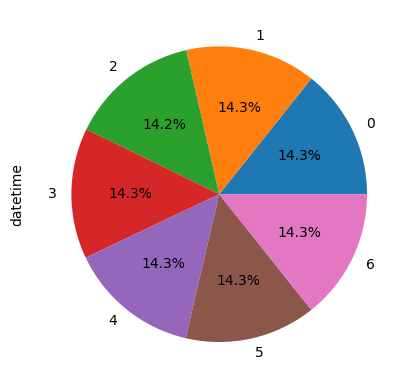

In [48]:
df['datetime'].apply(lambda x: x.weekday()).value_counts().sort_index().plot.pie(autopct='%1.1f%%');

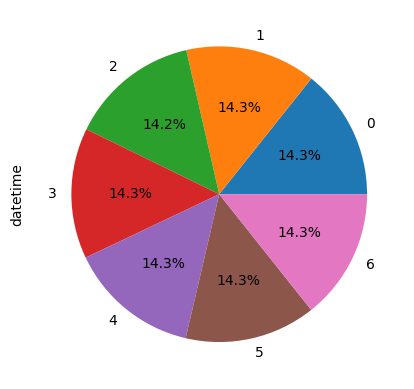

In [49]:
df_ex['datetime'].apply(lambda x: x.weekday()).value_counts().sort_index().plot.pie(autopct='%1.1f%%');

#### Week (target user)

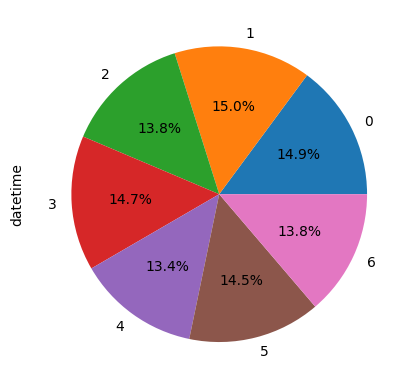

In [50]:
df_0_dt['datetime'].apply(lambda x: x.weekday()).value_counts().sort_index().plot.pie(autopct='%1.1f%%');

Distribution is almost equal for all of the groups.

#### Month

Here we will check only the target user because we're not interested in the distribution of the other users' activity.

In [51]:
df_0_dt

,browser,os,locale,gender,location,country,city,datetime
135245,Chrome,Ubuntu,ru-RU,m,France/Paris,France,Paris,2016-01-15 20:01:00
71532,Firefox,Windows 10,ru-RU,m,France/Paris,France,Paris,2016-01-17 10:32:00
67840,Firefox,Windows 10,ru-RU,m,France/Paris,France,Paris,2016-01-18 19:25:00
105767,Chrome,Ubuntu,ru-RU,m,France/Paris,France,Paris,2016-01-20 10:41:00
136479,Firefox,Ubuntu,ru-RU,m,France/Paris,France,Paris,2016-01-22 19:52:00
...,...,...,...,...,...,...,...,...
157345,Chrome,Windows 10,ru-RU,m,Singapore/Singapore,Singapore,Singapore,2019-04-15 14:10:00
41227,Chrome,Ubuntu,ru-RU,m,Singapore/Singapore,Singapore,Singapore,2019-04-17 04:18:00
119688,Chrome,Windows 10,ru-RU,m,Singapore/Singapore,Singapore,Singapore,2019-04-18 05:42:00
73075,Firefox,Ubuntu,ru-RU,m,Singapore/Singapore,Singapore,Singapore,2019-04-20 04:26:00


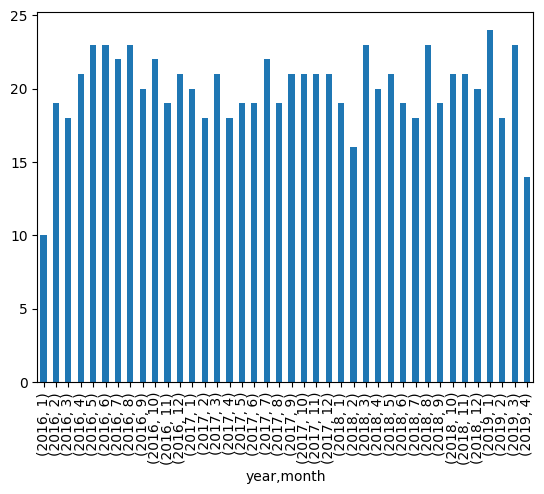

In [52]:
df_m = df_0_dt.copy()
df_m['year'] = df_m['datetime'].apply(lambda x: x.year)
df_m['month'] = df_m['datetime'].apply(lambda x: x.month)
df_m.groupby('year')['month'].value_counts().sort_index().plot.bar();

We can see there are no gaps or abnomal activity from the user 0 during the year.

### Sites

In [53]:
d[0]

{'browser': 'Chrome',
 'os': 'Windows 8',
 'locale': 'de-DE',
 'user_id': 164,
 'gender': 'm',
 'location': 'Canada/Toronto',
 'sites': [{'site': 'lenta.ru', 'length': 296},
  {'site': 'lenta.ru', 'length': 69},
  {'site': 'vk.com', 'length': 94},
  {'site': 'lenta.ru', 'length': 129},
  {'site': 'wikipedia.org', 'length': 70},
  {'site': 'instagram.com', 'length': 120},
  {'site': 'msn.com', 'length': 54},
  {'site': 'amazon.com', 'length': 213},
  {'site': 'outlook.com', 'length': 140},
  {'site': 'verisign.com', 'length': 166},
  {'site': 'googleadservices.com', 'length': 115},
  {'site': 'akamaiedge.net', 'length': 88},
  {'site': 'stardock.com', 'length': 207},
  {'site': 'mediaarea.net', 'length': 78}],
 'time': '03:57:00',
 'date': '2016-08-14'}

In [54]:
len(d)

160000

### Clicks

In [55]:
site_counter = ddict(int)
for u in d:
    for site in u['sites']:
        site_name = site['site']
        site_counter[site_name] += 1
site_counter = Counter(site_counter)
len(site_counter)

157771

In [56]:
site_counter.most_common(10)

[('amazon.com', 154135),
 ('wikipedia.org', 151104),
 ('vk.com', 56539),
 ('youtube.com', 45036),
 ('mail.google.com', 44960),
 ('slack.com', 44387),
 ('lenta.ru', 44028),
 ('toptal.com', 37416),
 ('netflix.com', 32274),
 ('scorecardresearch.com', 31108)]

10 most popular sites.

In [57]:
site_counter.most_common()[-30:]

[('fossweb.com', 1),
 ('gigastream19.xyz', 1),
 ('custream.com', 1),
 ('khpfmkpp.com', 1),
 ('natsdk.com', 1),
 ('vintageadbrowser.com', 1),
 ('albanyhs.com', 1),
 ('exdynsrv.com', 1),
 ('cdn12tube.pro', 1),
 ('jouwweb.nl', 1),
 ('vermontcreamery.com', 1),
 ('emailingstats.com', 1),
 ('aetnacareers.com', 1),
 ('parents.ru', 1),
 ('flyreagan.com', 1),
 ('tvkhorukspbdse.ki', 1),
 ('officefurniture.com', 1),
 ('irena.org', 1),
 ('passiton.com', 1),
 ('mmmicrosystems.com', 1),
 ('51cto.com', 1),
 ('uni-greifswald.de', 1),
 ('s4insight.com', 1),
 ('ftuwc.com', 1),
 ('trouva.com', 1),
 ('sharpservices.com', 1),
 ('shoponline.today', 1),
 ('claimlookup.com', 1),
 ('curbside.com', 1),
 ('netsky.club', 1)]

30 least popular sites.

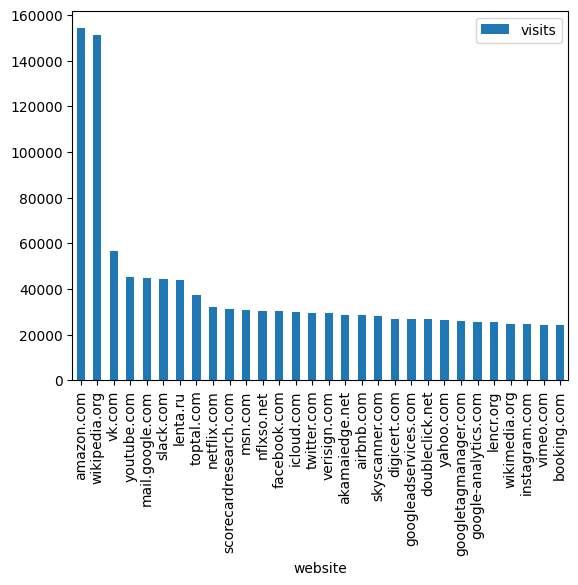

In [58]:
df_sites = pd.DataFrame(site_counter.items()).sort_values(1, ascending=False)
df_sites = df_sites.rename(columns={0: "website", 1: "visits"})
df_sites[:30].set_index("website").plot.bar();

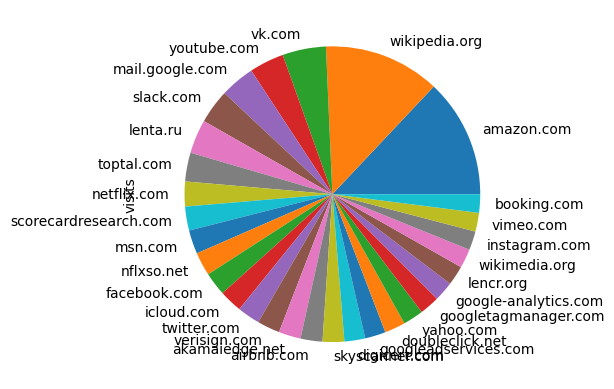

In [59]:
df_sites[:30].set_index("website")["visits"].plot.pie();

We can see that `amazon.com` and `wikipedia.org` are the most popular websites of all the users.

#### Sites - user 0

In [60]:
site_counter_0 = ddict(int)
for u in d:
    if u['user_id'] != 0:
        continue
    for site in u['sites']:
        site_name = site['site']
        site_counter_0[site_name] += 1
site_counter_0 = Counter(site_counter_0)
len(site_counter_0)

1515

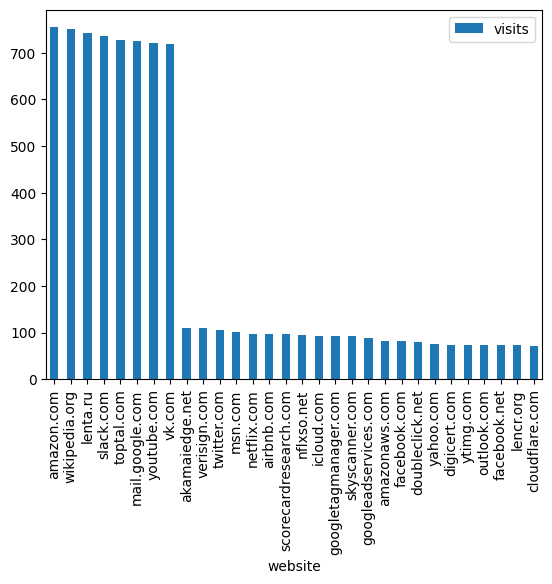

In [61]:
df_0_sites = pd.DataFrame(site_counter_0.items()).sort_values(1, ascending=False)
df_0_sites = df_0_sites.rename(columns={0: "website", 1: "visits"})
df_0_sites[:30].set_index("website").plot.bar();

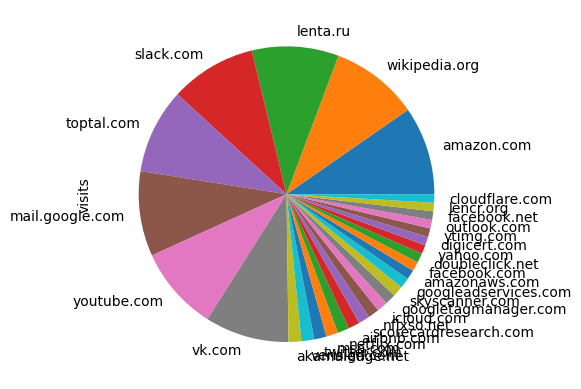

In [62]:
df_0_sites[:30].set_index("website")["visits"].plot.pie();

For the user 0 the situation is a bit different. This can be used as a valuable feature for identification.

#### Sites - ex. target user

In [63]:
site_counter_ex = ddict(int)
for u in d:
    if u['user_id'] == 0:
        continue
    for site in u['sites']:
        site_name = site['site']
        site_counter_ex[site_name] += 1
site_counter_ex = Counter(site_counter_ex)
len(site_counter_ex)

157436

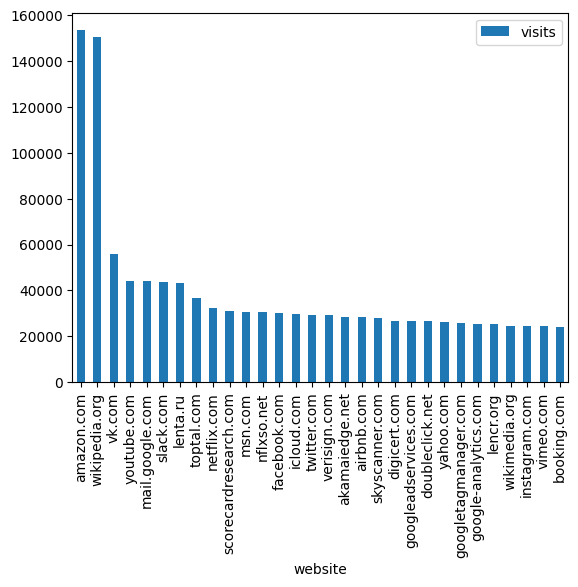

In [64]:
df_ex_sites = pd.DataFrame(site_counter_ex.items()).sort_values(1, ascending=False)
df_ex_sites = df_ex_sites.rename(columns={0: "website", 1: "visits"})
df_ex_sites[:30].set_index("website").plot.bar();

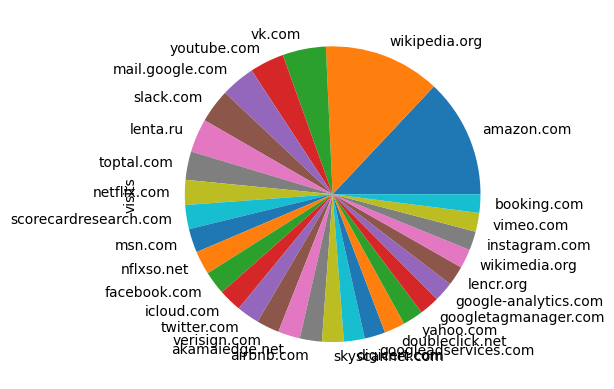

In [65]:
df_ex_sites[:30].set_index("website")["visits"].plot.pie();

### Time spent

In [66]:
site_counter = ddict(int)
for u in d:
    for site in u['sites']:
        site_name = site['site']
        site_counter[site_name] += site['length']
site_counter = Counter(site_counter)
len(site_counter)

157771

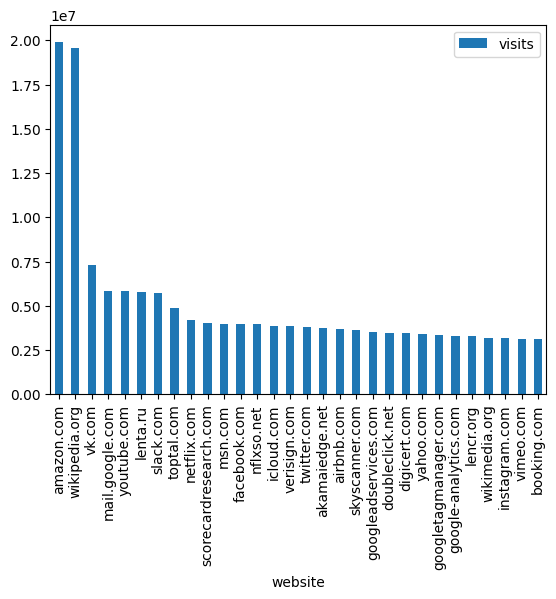

In [67]:
df_sites = pd.DataFrame(site_counter.items()).sort_values(1, ascending=False)
df_sites = df_sites.rename(columns={0: "website", 1: "visits"})
df_sites[:30].set_index("website").plot.bar();

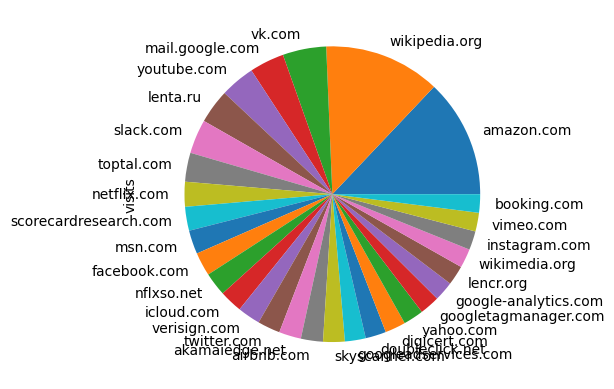

In [68]:
df_sites[:30].set_index("website")["visits"].plot.pie();

#### Sites - user 0

In [69]:
site_counter_0 = ddict(int)
for u in d:
    if u['user_id'] != 0:
        continue
    for site in u['sites']:
        site_name = site['site']
        site_counter_0[site_name] += site['length']
site_counter_0 = Counter(site_counter_0)
len(site_counter_0)

1515

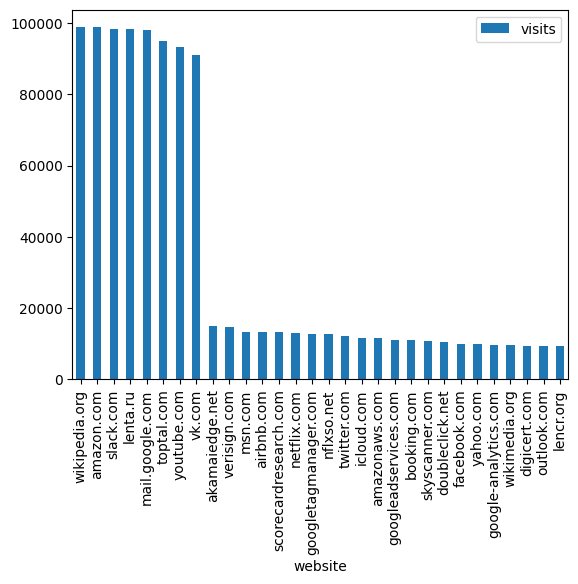

In [70]:
df_0_sites = pd.DataFrame(site_counter_0.items()).sort_values(1, ascending=False)
df_0_sites = df_0_sites.rename(columns={0: "website", 1: "time_spent"})
df_0_sites[:30].set_index("website").plot.bar();

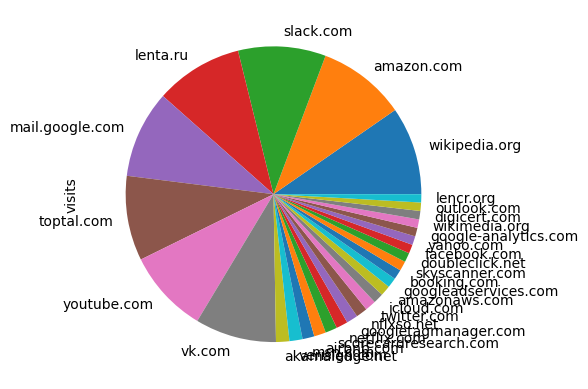

In [71]:
df_0_sites[:30].set_index("website")["time_spent"].plot.pie();

In [72]:
df_0_sites.sort_values('time_spent', ascending=False)[:10]

,website,visits
6,wikipedia.org,98830
7,amazon.com,98828
4,slack.com,98340
3,lenta.ru,98252
1,mail.google.com,98100
2,toptal.com,95080
5,youtube.com,93347
0,vk.com,91109
47,akamaiedge.net,14966
46,verisign.com,14651


In [73]:
sum(df_0_sites.sort_values('time_spent', ascending=False)[:8]['time_spent']) / sum(df_0_sites['time_spent'])

0.5613826598776849

We can see that there is a significant difference between the top 8 visited websites by our user and the rest of them. Taking these top 8 features we're covering 56% of all the clicks made by the target user.

In [74]:
sum(df_0_sites.sort_values('time_spent', ascending=False)[:30]['time_spent']) / sum(df_0_sites['time_spent'])

0.7458379182718498

Considering the top 30 websites by the usage of the target user we will cover almost 75% of the websites visited by the user.

### Combination of features

In [75]:
df_0[['browser', 'os', 'country']].value_counts()

browser  os          country  
Firefox  Ubuntu      France       84
Chrome   Ubuntu      France       80
         Windows 10  France       80
Firefox  Windows 10  France       73
                     USA          52
Chrome   Ubuntu      USA          51
Firefox  Ubuntu      Canada       49
Chrome   Windows 10  USA          44
Firefox  Windows 10  Canada       44
Chrome   Ubuntu      Canada       43
         Windows 10  Canada       42
Firefox  Ubuntu      USA          37
         Windows 10  Singapore    33
         Ubuntu      Singapore    30
Chrome   Ubuntu      Singapore    29
         Windows 10  Singapore    29
dtype: int64

#### Browser usage through the time

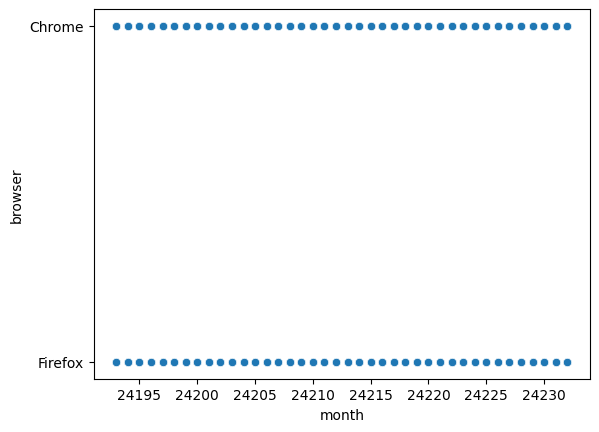

In [76]:
df_0_dt['month'] = df_0_dt['datetime'].apply(lambda x: x.year * 12 + x.month)
sns.scatterplot(data=df_0_dt, x="month", y="browser");

It doesn't look like the user have switched from one browser to another at some point of time.

In [77]:
df_0_dt['day_of_week'] = df_0_dt['datetime'].apply(lambda x: x.weekday())

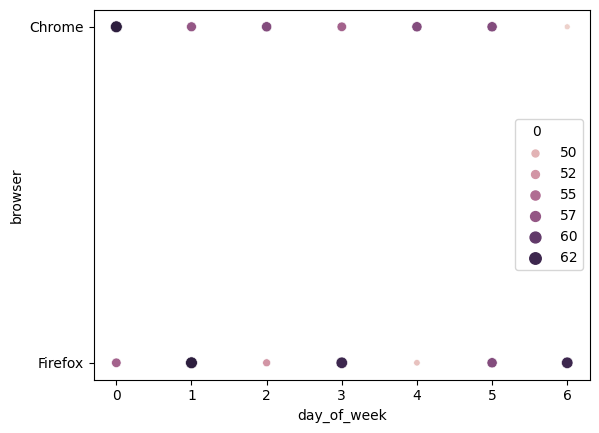

In [78]:
vc = df_0_dt[["browser", 'day_of_week']].value_counts().reset_index().sort_values(by=['day_of_week', 'browser'])
sns.scatterplot(data=vc, x="day_of_week", y="browser", hue=0, size=0);

During the week both browsers are used.

In [79]:
df_0_dt['hour'] = df_0_dt['datetime'].apply(lambda x: x.hour)

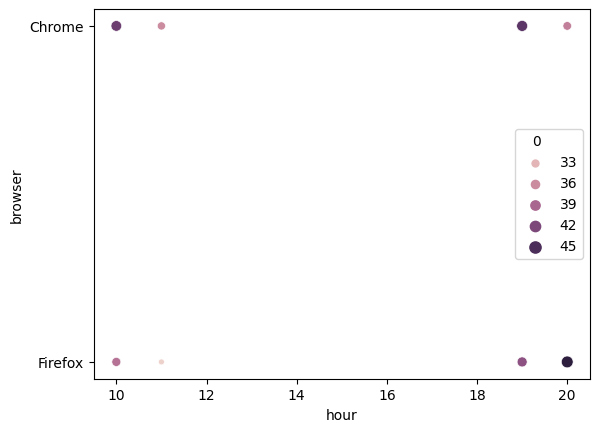

In [80]:
vc = df_0_dt[df_0_dt['country']=='France'][["browser", 'hour']].value_counts().reset_index().sort_values(by=['hour', 'browser'])
sns.scatterplot(data=vc, x="hour", y="browser", hue=0, size=0);

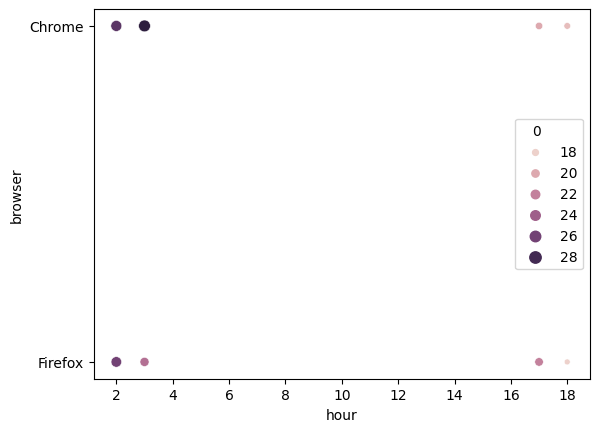

In [81]:
vc = df_0_dt[df_0_dt['country']=='USA'][["browser", 'hour']].value_counts().reset_index().sort_values(by=['hour', 'browser'])
sns.scatterplot(data=vc, x="hour", y="browser", hue=0, size=0);

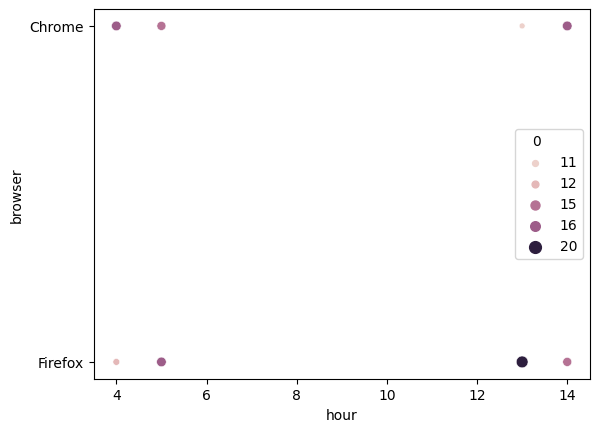

In [82]:
vc = df_0_dt[df_0_dt['country']=='Singapore'][["browser", 'hour']].value_counts().reset_index().sort_values(by=['hour', 'browser'])
sns.scatterplot(data=vc, x="hour", y="browser", hue=0, size=0);

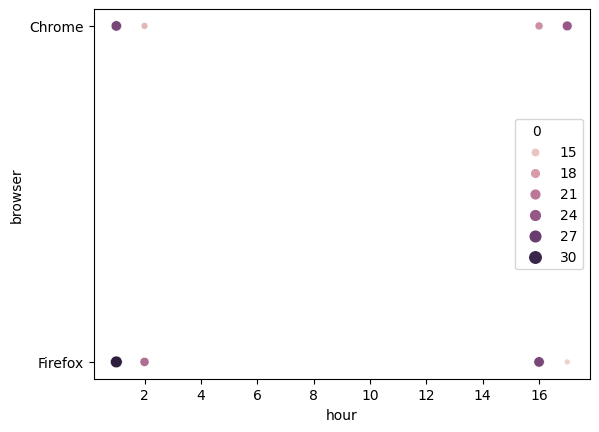

In [83]:
vc = df_0_dt[df_0_dt['country']=='Canada'][["browser", 'hour']].value_counts().reset_index().sort_values(by=['hour', 'browser'])
sns.scatterplot(data=vc, x="hour", y="browser", hue=0, size=0);

We can make an assumption that the user uses 2 browsers in prarllel / interchangebly.

#### OS usage through the time

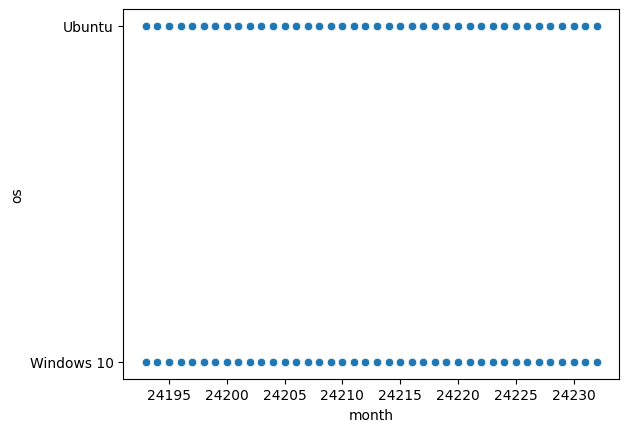

In [84]:
sns.scatterplot(data=df_0_dt, x="month", y="os");

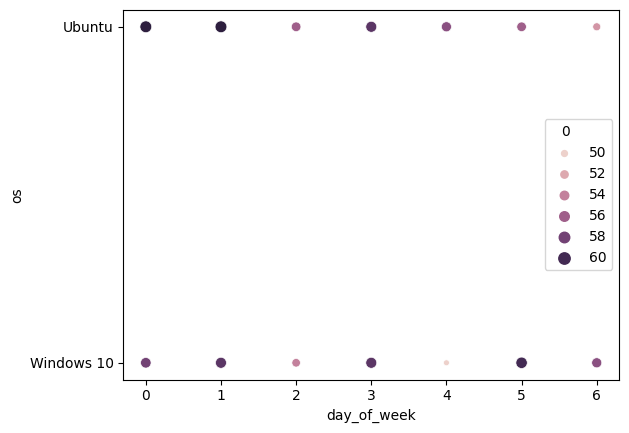

In [85]:
vc = df_0_dt[["os", 'day_of_week']].value_counts().reset_index().sort_values(by=['day_of_week', 'os'])
sns.scatterplot(data=vc, x="day_of_week", y="os", hue=0, size=0);

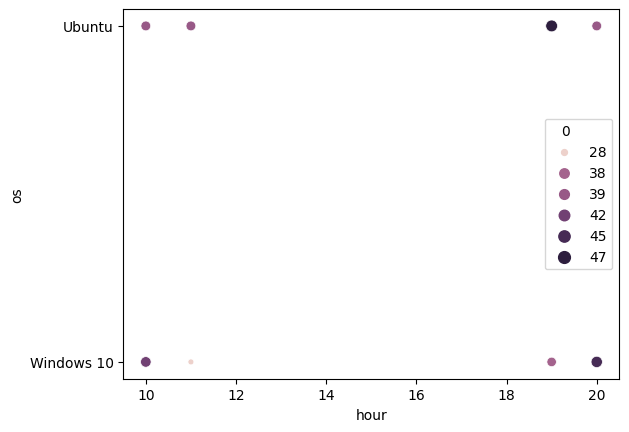

In [86]:
vc = df_0_dt[df_0_dt['country']=='France'][["os", 'hour']].value_counts().reset_index().sort_values(by=['hour', 'os'])
sns.scatterplot(data=vc, x="hour", y="os", hue=0, size=0);

We can observe the same pattern as with the feature "browser".

#### Country & City usage through the time

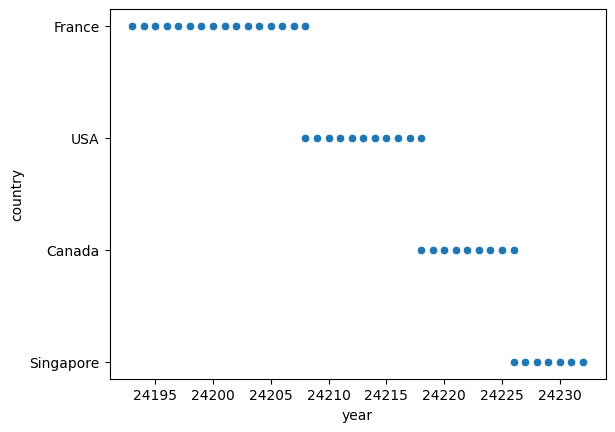

In [87]:
df_0_dt['year'] = df_0_dt['datetime'].apply(lambda x: x.year * 12 + x.month)
sns.scatterplot(data=df_0_dt, x="year", y="country");

Based on the time distribution, we can conclude that the user probably didn't use any VPNs (otherwise the countries would have similar distribution over time). And, based on the last time records, the user is now located in Singapore.

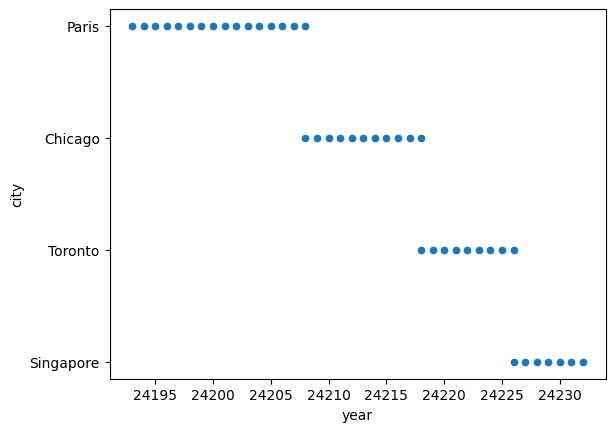

In [88]:
sns.scatterplot(data=df_0_dt, x="year", y="city");

Each of the cities the target user had sessions corresponds to a unique country from the previous point. The date pattern also matches.

#### Target

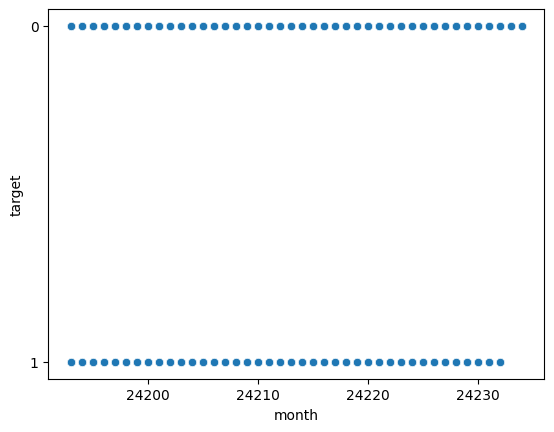

In [89]:
df['month'] = df['datetime'].apply(lambda x: x.year * 12 + x.month)
sns.scatterplot(data=df, x="month", y="target");

In [90]:
df['datetime'].max()

Timestamp('2019-06-18 09:07:00')

In [91]:
df_0_dt['datetime'].max()

Timestamp('2019-04-21 14:31:00')

The data about the target user stops a couple of months before the last session in the dataset.

## Preprocessing

### OHE

In [92]:
df_dum = pd.get_dummies(df[['browser', 'os', 'gender', 'locale_ru', 'location']], drop_first=True)
df = pd.concat([df, df_dum], axis=1)

df = df.drop(['browser', 'os', 'gender', 'locale_ru', 'user_id', 'locale', 'location', 'month', 'country', 'city'], axis=1)

### Datetime

In [93]:
df_dt = gen_date(df, date_feature_name='datetime')
df = pd.concat([df, df_dt], axis=1)

### Sites

In [94]:
def session_total_time(x):
    return sum([site['length'] for site in x])

df['session_total_time'] = df['sites'].apply(session_total_time)

In [95]:
def session_avg_time(x):
    return sum([site['length'] for site in x]) / len(x)

df['session_avg_time'] = df['sites'].apply(session_avg_time)

In [96]:
def session_n_sites(x):
    return len(x)

df['session_n_sites'] = df['sites'].apply(session_n_sites)

## Train/test split

we will be using the time series cross-validation split to avoid data leak.

In [118]:
%%time
df_ = df.set_index('datetime').sort_index()
X = df_.drop('target', axis=1)
y = df_[['target']]

Xy_train_list = []
Xy_test_list = []

tscv = TimeSeriesSplit(max_train_size=None, n_splits=4)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Fold {i}:\nX_train - start date:\t{X_train.index.min()}")
    print(f"X_train - end date:\t{X_train.index.max()}")
    print(f"X_test - start date:\t{X_test.index.min()}")
    print(f"X_test - end date:\t{X_test.index.max()}\n")

    # Websites encoding, do this after the train/test split to avoid data leak
    top_n = 30
    X_train, X_test, _ = gen_topn_sites(X_train, X_test, y_train, n=top_n)

    Xy_train_list.append((X_train, y_train))
    Xy_test_list.append((X_test, y_test))

Fold 0:
X_train - start date:	2016-01-14 12:42:00
X_train - end date:	2016-09-10 08:21:00
X_test - start date:	2016-09-10 08:23:00
X_test - end date:	2017-05-08 04:50:00

Fold 1:
X_train - start date:	2016-01-14 12:42:00
X_train - end date:	2017-05-08 04:50:00
X_test - start date:	2017-05-08 04:51:00
X_test - end date:	2018-01-02 13:13:00

Fold 2:
X_train - start date:	2016-01-14 12:42:00
X_train - end date:	2018-01-02 13:13:00
X_test - start date:	2018-01-02 13:16:00
X_test - end date:	2018-08-30 08:48:00

Fold 3:
X_train - start date:	2016-01-14 12:42:00
X_train - end date:	2018-08-30 08:48:00
X_test - start date:	2018-08-30 09:03:00
X_test - end date:	2019-06-18 09:07:00

CPU times: total: 36.6 s
Wall time: 36.6 s


## Normalization

We also conduct scaling after the train/test split to avoid data leak.

In [98]:
scalers = []
for i in range(len(Xy_train_list)):
    X_train, y_train = Xy_train_list[i]
    X_test, y_test = Xy_train_list[i]

    scaler = StandardScaler()
    cols_to_scale = X_train.columns[-top_n-3:]  # top N sites & 3 session characteristics
    X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
    X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

    scalers.append(scaler)
    Xy_train_list[i] = (X_train, y_train)
    Xy_test_list[i] = (X_test, y_test)

In [117]:
X_train.shape[1]

73

73 features is not so many, feature importance analysis will be conducted after the modelling step.

# Modelling

## Baseline - LogReg

Logistic regression is the baseline for the binary classification problem.

In [99]:
%%time
for i in range(len(Xy_train_list)):
    X_train, y_train = Xy_train_list[i]
    X_test, y_test = Xy_train_list[i]

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    lr = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    f1_mic = round(f1_score(y_test, y_pred, average='micro'), 3)
    f1_mac = round(f1_score(y_test, y_pred, average='macro'), 3)
    prec = round(precision_score(y_test, y_pred), 3)
    rec = round(recall_score(y_test, y_pred), 3)
    print(f"Fold {i}: F1(micro): {f1_mic}, F1(macro): {f1_mac}, Precision: {prec}, Recall: {rec}")

Fold 0: F1(micro): 0.968, F1(macro): 0.616, Precision: 0.141, Recall: 1.0
Fold 1: F1(micro): 0.954, F1(macro): 0.577, Precision: 0.098, Recall: 0.991
Fold 2: F1(micro): 0.945, F1(macro): 0.563, Precision: 0.084, Recall: 1.0
Fold 3: F1(micro): 0.94, F1(macro): 0.556, Precision: 0.077, Recall: 1.0
CPU times: total: 37.2 s
Wall time: 7.39 s


## XGB

Gradient Boosting is the default approach for working with the tabular data classification.

In [100]:
%%time
for i in range(len(Xy_train_list)):
    X_train, y_train = Xy_train_list[i]
    X_test, y_test = Xy_train_list[i]

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    xgb = XGBClassifier(random_state=RANDOM_STATE, n_estimators=200, max_depth=15)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    f1_mic = round(f1_score(y_test, y_pred, average='micro'), 3)
    f1_mac = round(f1_score(y_test, y_pred, average='macro'), 3)
    prec = round(precision_score(y_test, y_pred), 3)
    rec = round(recall_score(y_test, y_pred), 3)
    print(f"Fold {i}: F1(micro): {f1_mic}, F1(macro): {f1_mac}, Precision: {prec}, Recall: {rec}")

Fold 0: F1(micro): 1.0, F1(macro): 1.0, Precision: 1.0, Recall: 1.0
Fold 1: F1(micro): 1.0, F1(macro): 1.0, Precision: 1.0, Recall: 1.0
Fold 2: F1(micro): 1.0, F1(macro): 1.0, Precision: 1.0, Recall: 1.0
Fold 3: F1(micro): 1.0, F1(macro): 1.0, Precision: 1.0, Recall: 1.0
CPU times: total: 5min 22s
Wall time: 36.4 s


Based on the results of the cross-validation, we can choose the XGB classifier to be the resulting model.

#### Feature importance

#### Gain

In [102]:
df_fi = pd.DataFrame(zip(xgb.get_booster().feature_names, xgb.feature_importances_)) \
    .rename(columns={0: 'Feature', 1: 'importance'}) \
    .sort_values('importance', ascending=False)
df_fi[:10]

,Feature,importance
4,os_Ubuntu,0.109660
13,location_France/Paris,0.097835
25,location_USA/Chicago,0.060682
32,cos_hour,0.047561
8,gender_m,0.045966
31,sin_hour,0.043738
5,os_Windows 10,0.038305
48,lenta.ru,0.024972
7,os_Windows 8,0.024197
49,slack.com,0.019013


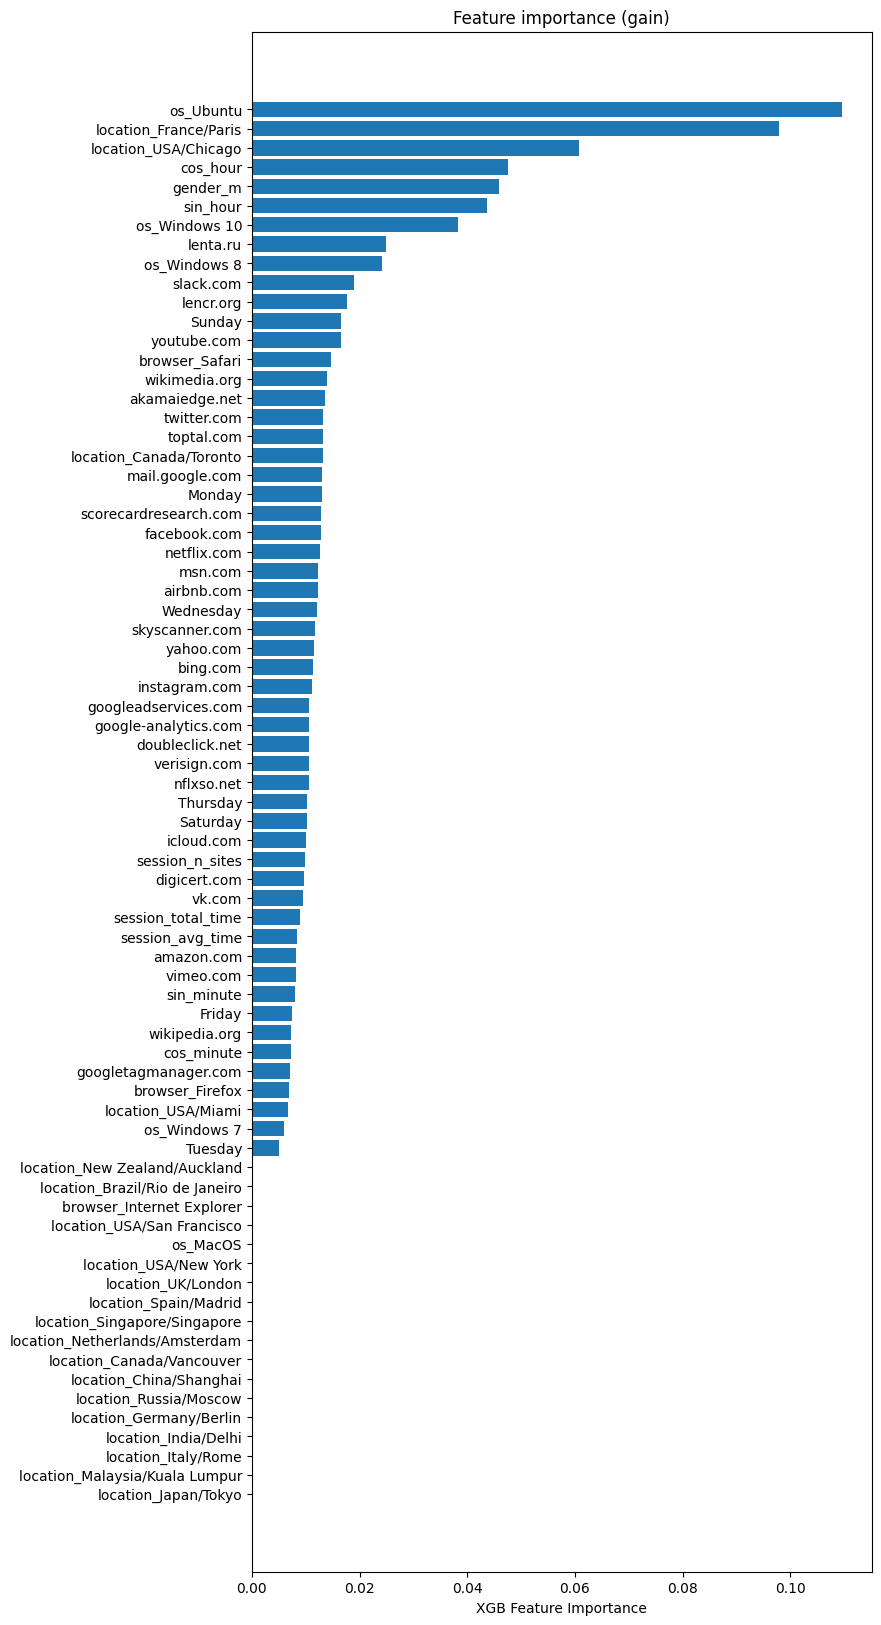

In [103]:
idx = np.argsort(xgb.feature_importances_)
plt.figure(figsize=(8,20))
plt.title("Feature importance (gain)")
plt.xlabel("XGB Feature Importance")
plt.barh(X_train.columns[idx], xgb.feature_importances_[idx]);

#### Weight

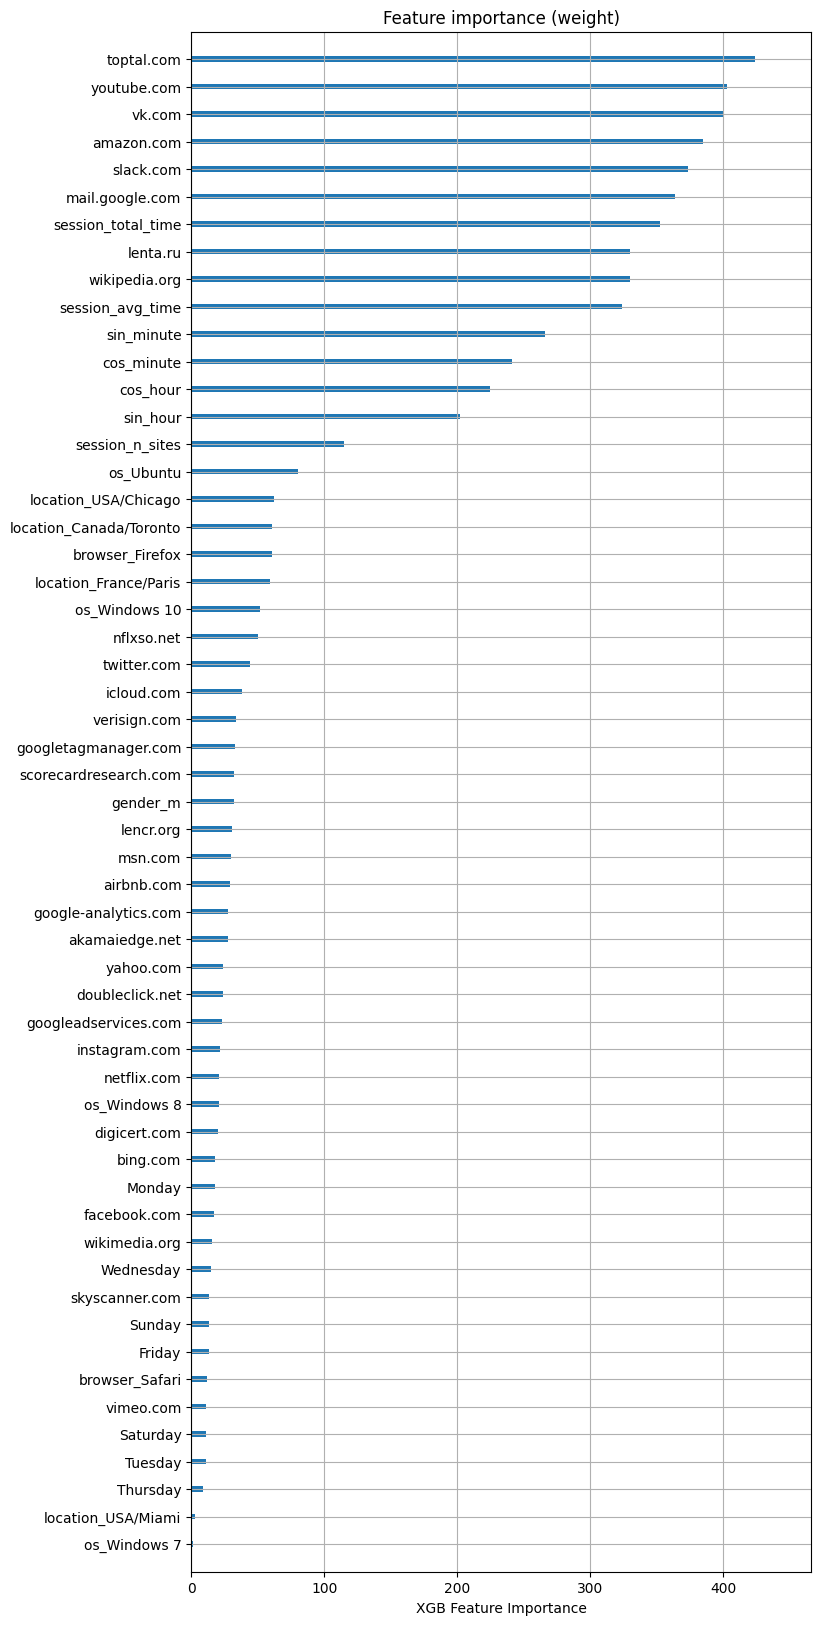

In [104]:
plt.figure(figsize=(8, 20))
ax = plt.axes()
plot_importance(xgb, ax, importance_type='weight', show_values=False, \
    xlabel="XGB Feature Importance", ylabel="")
plt.title("Feature importance (weight)")
plt.show();

# Final algorithm

Here we use the whole dataset to train the model that will go to production.

In [105]:
%%time
df_ = df.set_index('datetime').sort_index()
X = df_.drop('target', axis=1)
y_train = df_[['target']].astype(int)

X_train, _, topn_sites_features = gen_topn_sites(X, X, y_train, n=top_n)

scaler = StandardScaler()
cols_to_scale = X_train.columns[-top_n-3:]
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

CPU times: total: 22.3 s
Wall time: 22.3 s


In [106]:
%%time
xgb = XGBClassifier(random_state=RANDOM_STATE, n_estimators=200, max_depth=15)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)

CPU times: total: 5min 13s
Wall time: 31.9 s


In [107]:
artifcats = {
    'scaler': scaler,
    'xgb': xgb,
    'topn_sites_features': topn_sites_features,
    'columns': X_train.columns
}

with open('artifacts.pkl', 'wb') as f:
    pickle.dump(artifcats, f, protocol=pickle.HIGHEST_PROTOCOL)

## Coherence check

In [108]:
f1_mic = round(f1_score(y_train, y_pred, average='micro'), 3)
f1_mac = round(f1_score(y_train, y_pred, average='macro'), 3)
prec = round(precision_score(y_train, y_pred), 3)
rec = round(recall_score(y_train, y_pred), 3)

print(f"F1(micro): {f1_mic}, F1(macro): {f1_mac}, Precision: {prec}, Recall: {rec}")

F1(micro): 1.0, F1(macro): 1.0, Precision: 1.0, Recall: 1.0


## Module test

Activate the `venv` using the `requirements.txt` and run the following command in your terminal:
```python
python -m script "data/dataset.json"
```

In [112]:
y_module_test = pd.DataFrame(d)['user_id']
y_module_test = (y_module_test != 0).astype(int)

In [113]:
y_module_test_pred = pd.read_csv("results.csv", header=None)

In [114]:
f1_mic = round(f1_score(y_module_test, y_module_test_pred, average='micro'), 3)
f1_mac = round(f1_score(y_module_test, y_module_test_pred, average='macro'), 3)
prec = round(precision_score(y_module_test, y_module_test_pred), 3)
rec = round(recall_score(y_module_test, y_module_test_pred), 3)

print(f"F1(micro): {f1_mic}, F1(macro): {f1_mac}, Precision: {prec}, Recall: {rec}")

F1(micro): 1.0, F1(macro): 1.0, Precision: 1.0, Recall: 1.0
